# Feature Selection Comparison: RSCFI vs RFECV

This notebook presents a comparison between two feature selection methods: 
- **[RFECV](https://scikit-learn.org/1.5/modules/generated/sklearn.feature_selection.RFECV.html)**: A widely adopted feature selection method in digital soil mapping (DSM).
- **RSCFI**: Repeated Subsampling-Based Cumulative Feature Importance, a new method developed in this study to address the challenge of identifying optimal feature sets from a large number of features (over 500) on a large dataset (calibration set with 8,000 points).

### Methodology:
1. **Feature Selection**: 
   - Both methods were applied to perform feature selection.
   - Time taken and the number of features selected were recorded.
   - For both methods, 5-fold cross-validation was used during the feature elimination process.

2. **Model Evaluation**: 
   - Naive random forest (RF) models were trained on the features selected by each method.
   - Model performance was assessed using 5-fold cross-validation.

### Notes:
- All experiments in this notebook were conducted on the calibration dataset.


In [1]:
import sys
import pathlib
import os
from skmap.catalog import DataCatalog
from skmap.loader import TiledDataLoader
from skmap.overlay import SpaceOverlay, SpaceTimeOverlay
from skmap.misc import find_files, GoogleSheet, ttprint
import random
import pandas as pd
import time
import skmap_bindings as sb
import numpy as np
import geopandas as gpd
import json
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, cross_val_score, HalvingGridSearchCV, KFold, GroupKFold, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error, make_scorer, median_absolute_error
from sklearn.ensemble import RandomForestRegressor
from model_fit import read_features, parameter_fine_tuning, evaluate_model, weighted_ccc, separate_data
import matplotlib.pyplot as plt
folder_path = '/home/xuemeng/work_xuemeng/soc/SoilHealthDataCube'
version = '20250404'

## Prepare

In [2]:
# read in
cal = pd.read_parquet(f'{folder_path}/data/005_data_cal_v{version}.pq')

with open(f'{folder_path}/data/007_cov_all.json', "r") as file:
    covs_all = json.load(file)
   
print('initial feature number: ', len(covs_all))
# initialize some parameter
n_jobs=90
cv = GroupKFold(n_splits=5) 
rsl = []
prop = 'ocd'
space = 'log1p'
tgt = f'{prop}_log1p'

cal[tgt] = np.log1p(cal[prop])


initial feature number:  585


In [3]:
# exclude accumulative features to avoid un-realistic SOCD changes
drop_list = []
for ii in covs_all:
    if 'accum' in ii:
        if 'landsat' in ii:
            drop_list.append(ii)
            
    # if '_n_' in ii:
    #     drop_list.append(ii)
            
covs_all = [ii for ii in covs_all if ii not in drop_list]

In [4]:
len(covs_all)

582

## RSCFI

### Methodology explaination, key steps:
1. **Calculating Cumulative Feature Importance (CFI)**:
   - Before feature elimination, CFI values were calculated by repeatedly fitting a Random Forest (RF) model with default settings to subsets of approximately 70% of the entire dataset.
   - The dataset subsets were selected in a spatially-blocked manner to ensure data from specific spatial tiles were used in different iterations.
   - Over 20 iterations, feature importance was recorded, accumulated, and then averaged to derive the CFI for each feature candidate.
   - This approach identifies features that consistently contribute to model performance across various data subsets.

2. **Feature Elimination Process**:
   - The process began with a CFI threshold of 0, including all features as the baseline.
   - The threshold was incrementally increased by 0.0005 at each step, eliminating features with CFI values below the threshold, until only two features remained.
   - At each step, model performance was evaluated using 5-fold spatial cross-validation.

3. **Determining the Optimal Feature Set**:
   - The threshold that yielded the best performance metrics determined the optimal feature set for further analysis.


start bootstrap on different subset...
[13:23:37] 0 iteration, training size: 3697
[13:23:42] 1 iteration, training size: 3437
[13:23:47] 2 iteration, training size: 3422
[13:23:51] 3 iteration, training size: 3504
[13:23:56] 4 iteration, training size: 3266
[13:24:01] 5 iteration, training size: 3782
[13:24:06] 6 iteration, training size: 3494
[13:24:11] 7 iteration, training size: 3161
[13:24:16] 8 iteration, training size: 3168
[13:24:20] 9 iteration, training size: 3537
[13:24:25] 10 iteration, training size: 3147
[13:24:29] 11 iteration, training size: 3535
[13:24:33] 12 iteration, training size: 3625
[13:24:38] 13 iteration, training size: 3688
[13:24:43] 14 iteration, training size: 3587
[13:24:48] 15 iteration, training size: 3418
[13:24:53] 16 iteration, training size: 3887
[13:24:58] 17 iteration, training size: 2698
[13:25:01] 18 iteration, training size: 3279
[13:25:06] 19 iteration, training size: 3578
start feature elimination evaluation...
[13:25:11] processing 0.0 ...
[

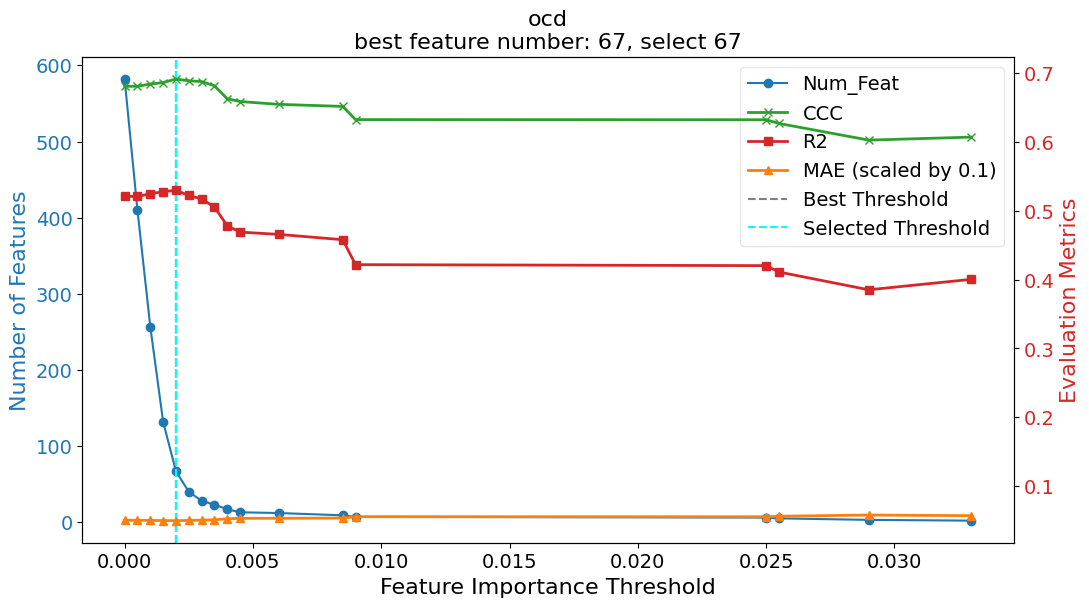

cfi calculation used 3.1482024868329366 mins


In [5]:
from model_fit import cfi_calc, rscfi

# run from scratch
start = time.time()
cfi = cfi_calc(cal, tgt, prop, space, folder_path, covs_all, version) #, weights_feature=None, threshold_step=0.00
cfi = pd.read_csv(f'{folder_path}/cumulative.feature.importance_{prop}_v{version}.csv')
covs = rscfi(cal, tgt, prop, space, folder_path, covs_all, cfi, threshold_step=0.0005) #, weights_feature=None)
end = time.time()
time_used = (end-start)/60
print(f'cfi calculation used {time_used} mins')

### Key features of RSCFI:

The feature elimination process using CFI is depicted in the plot above. This process has several key characteristics:

- **Derivation of CFI**: CFI is calculated from different subsets of the dataset, enabling the identification of features that consistently contribute to improved model performance.
- **Feature Elimination**: Features are removed based on their CFI values, with those below a predefined threshold eliminated at each step.
- **Multi-Metric Decision-Making**: The final decision on the optimal feature set is based on multiple performance metrics. In our case, we considered CCC, R², MAE, and MedAE when selecting the best feature set. (MedAE is not shown in the plot due to visualization reasons.)

## RFECV

RFECV (Recursive Feature Elimination with Cross-Validation) builds upon Recursive Feature Elimination (RFE) by incorporating cross-validation to determine the optimal number of features. RFE selects features by iteratively removing the least important ones, re-training the model on the remaining features and record the model performance. At each step, a subset of features is eliminated, and the process continues until the pre-defined least allowed feature number is achieved.

Here, the step size is set to 10, meaning 10 features are eliminated at each step, reducing the feature set from the full set down to just 2 features. At each step, cross-validation is performed to ensure the selected feature set delivers optimal performance across validation folds.

In [5]:
from sklearn.feature_selection import RFECV, RFE
from scipy.signal import argrelmin, argrelmax
import joblib
import multiprocessing
from model_fit import calc_ccc

ccc_scorer = make_scorer(calc_ccc, greater_is_better=True)

rf = RandomForestRegressor(random_state=41, n_jobs=-1, n_estimators=100) # default
ttprint('start')
rfecv = RFECV(rf, cv=cv, step=10, min_features_to_select= 2, scoring=ccc_scorer, verbose=0)
start = time.time()
rfecv.fit(cal[covs_all], cal[tgt], groups=cal['tile_id'])
end = time.time()
time_rfecv = (end-start)/60

print(f'rfecv used {time_rfecv} mins')

[13:29:05] start
rfecv used 24.054501342773438 mins


In [6]:
# save features
selected_features = np.array(covs_all)[rfecv.support_]
with open(f'{folder_path}/benchmark_selected.covs.rfecv_{prop}_v{version}.txt', 'w') as file:
    for item in selected_features:
        file.write(f"{item}\n")

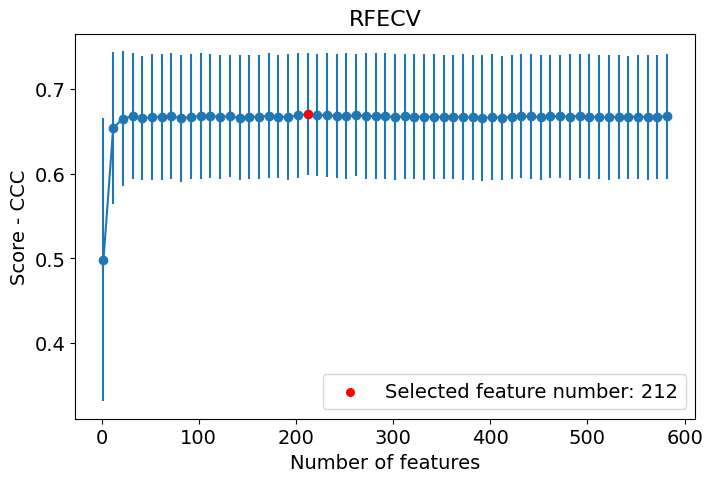

In [7]:
# Plotting the RFECV result

num_features = np.arange(len(covs_all),2,-10)
num_features = num_features[::-1]
num_features = np.insert(num_features, 0, 2)
plt.figure(figsize=(8, 5))
plt.errorbar(
    x=num_features,
    y=rfecv.cv_results_['mean_test_score'],
    yerr=rfecv.cv_results_["std_test_score"],
    fmt='-o'
)
# plt.axvline(x=rfecv.n_features_, color='red', linestyle='--')
a = np.argmax(rfecv.cv_results_['mean_test_score'])
plt.scatter(rfecv.n_features_, max(rfecv.cv_results_['mean_test_score']), color='red', s=30, zorder=5,label=f'Selected feature number: {rfecv.n_features_}')
plt.xlabel('Number of features', fontsize=14)
plt.ylabel('Score - CCC', fontsize=14)
plt.title('RFECV', fontsize=16)
plt.legend(loc='lower right',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig(f'{folder_path}/figure/plot_rfecv_v{version}.pdf', dpi=300, bbox_inches='tight')
plt.show()




### Comparison of RFECV and RSCFI: Time Efficiency

RFECV requires significantly more time than RSCFI because cross-validation must be performed approximately 50 times (reducing from over 500 features to just 2, with a step size of 10). 

In contrast, RSCFI bases elimination on CFI values. As shown in the RSCFI plot, most features have a minimal impact on the model (CFI < 0.0005). This allows a large number of features to be efficiently eliminated during the first few steps. This efficiency is clearly reflected in the stable—or even improved—model performance observed as the number of remaining features drops sharply during the initial elimination steps.

## Model evaluation

In [9]:
# features
covs_rscfi = read_features(f'{folder_path}/data/008_cov_rscfi.txt')
# covs_rscfi = read_features('/home/xuemeng/work_xuemeng/soc/SoilHealthDataCube/benchmark_selected.covs_ocd.txt')
print('num-feat selected by rscfi: ', len(covs_rscfi))
# covs_rfecv = read_features(f'/home/xuemeng/work_xuemeng/soc/SoilHealthDataCube/benchmark_selected.covs.rfecv_ocd.txt')
covs_rfecv = read_features(f'{folder_path}/data/009_cov_rfecv.txt')
print('num-feat selected by rfecv: ', len(covs_rfecv))

covs_both = [covs_rscfi, covs_rfecv]

# models, only test rf
rf = RandomForestRegressor(random_state=60, n_jobs=-1) # default

num-feat selected by rscfi:  67
num-feat selected by rfecv:  212


[14:26:52] cross val predict ocd, in log1p space


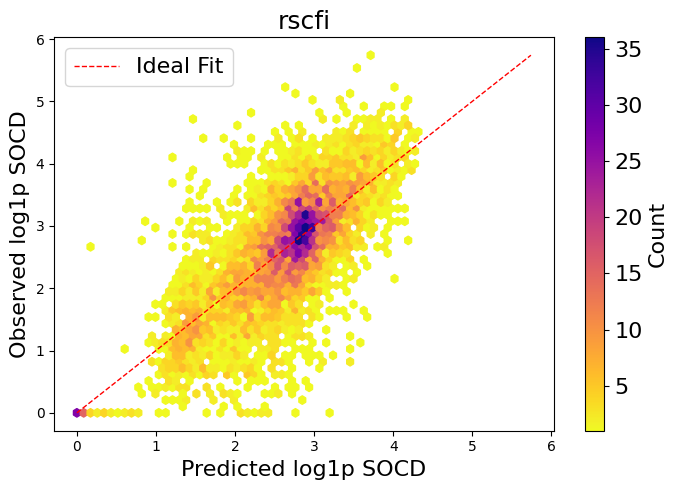

[14:26:59] cross val predict ocd, in log1p space


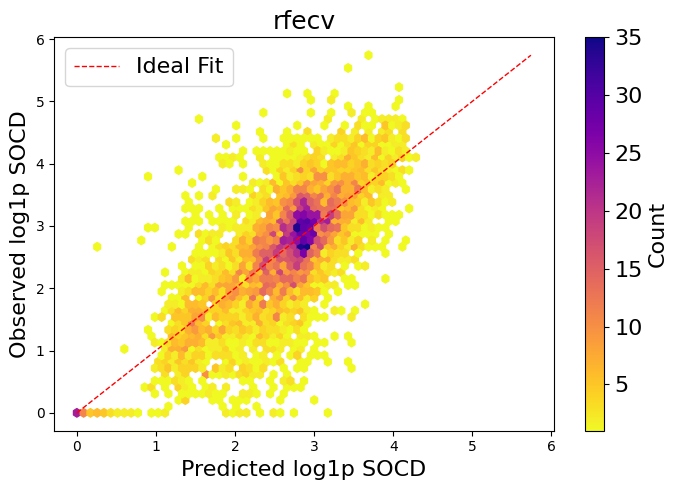

In [10]:
results = []

# evaluate
cv = GroupKFold(n_splits=5)
covs_name = ['rscfi','rfecv']
for icov in [0,1]:
    covs = covs_both[icov]
    name_cov = covs_name[icov]

    ttprint(f'cross val predict {prop}, in {space} space')
    y_cv = cross_val_predict(rf, cal[covs], cal[tgt], cv=cv, groups=cal['tile_id'], n_jobs=90)

    # ttprint(f'validation on test data for {prop}, in {space} space')
    # rf.fit(train[covs], train[tgt])
    # y_val = rf.predict(test[covs])

    # MAE is reported in original scale, while R2 and CCC are reported in log1p scale
    results.append({
        'property': prop,
        'covs':name_cov,
        'MAE_cv': mean_absolute_error(cal[prop],np.expm1(y_cv)),
        'MedAE_cv': median_absolute_error(cal[prop],np.expm1(y_cv)),
        # 'MAE_val': mean_absolute_error(test[prop],np.expm1(y_val)),
        'MAPE_cv': mean_absolute_percentage_error(cal[prop],np.expm1(y_cv)),
        # 'MAPE_val': mean_absolute_percentage_error(test[prop],np.expm1(y_val)),
        'R2_cv': r2_score(cal[prop],np.expm1(y_cv)),
        'R2_log': r2_score(cal[tgt],y_cv),
        'CCC_cv': weighted_ccc(cal[prop],np.expm1(y_cv)),
        'CCC_log': weighted_ccc(cal[tgt],y_cv),
        'feat_num': len(covs)
    })
    
    # Generate a hexbin heat map of absolute errors
    plt.figure(figsize=(7, 5))
    plt.hexbin(y_cv, cal[tgt], gridsize=50, cmap='plasma_r', mincnt=1, reduce_C_function=np.mean)
    cb = plt.colorbar(label='Count')  # Create the colorbar and set the label
    cb.set_label('Count', fontsize=16)  # Adjust the label font size
    cb.ax.tick_params(labelsize=16)  # Adjust the tick label font size
    plt.plot([cal[tgt].min(), cal[tgt].max()], [cal[tgt].min(), cal[tgt].max()], 'r--', linewidth=1, label='Ideal Fit')
    plt.xlabel('Predicted log1p SOCD',fontsize=16)
    plt.ylabel('Observed log1p SOCD',fontsize=16)
    plt.title(name_cov, fontsize = 18)
    plt.legend(fontsize=16)
    plt.tight_layout()
    # plt.savefig(f'hexbin_{name_cov}.png', dpi=300)
    plt.show()

In [7]:
results = pd.DataFrame(results)
results['time (min)'] = [3.21, 23.55]
results.to_csv(f'{folder_path}/metrics/metrics_rfecv.rscfi',index=False)
results

,property,covs,MAE_cv,MedAE_cv,MAPE_cv,R2_cv,R2_log,CCC_cv,CCC_log,feat_num,time (min)
0,ocd,rscfi,9.050738,5.022275,1.260801e+14,0.351802,0.529313,0.511293,0.690815,67,3.21
1,ocd,rfecv,9.119662,5.044931,1.332685e+14,0.341619,0.525384,0.499259,0.685771,212,23.55


### Results analysis 

The features selected by RSCFI, though fewer in number than those selected by RFECV, achieved comparable (slightly better) performance. 

Combined with other advantages offered by RSCFI, as outlined in our earlier analysis, and the results from the model experiments, we chose RSCFI as our feature selection method. This decision allowed us to achieve strong performance while maintaining efficiency.


# CFI analysis for dynamic and static features

In [8]:
scov = read_features(f'{folder_path}/data/008_cov_rscfi.txt') # read in selected features
ncov = read_features(f'{folder_path}/data/014_cov.name_rscfi.txt') # read in selected features names
landsat_cov = []
chelsa_cov = []
lst_cov = []
dtm_cov = []
pr_cov = []
wv_cov = []
for ii in scov:
    if 'glad.lan' in ii:
        landsat_cov.append(ii)
    elif 'pr' in ii:
        pr_cov.append(ii)
    elif 'lst' in ii:
        lst_cov.append(ii)
    elif '_ensemble_' in ii:
        dtm_cov.append(ii)
    elif '_chelsa' in ii:
        chelsa_cov.append(ii)
    elif 'wv_' in ii:
        wv_cov.append(ii)
    else:
        print(ii)
        
print(f'select {len(landsat_cov)} landsat covariates')
print(f'select {len(chelsa_cov)} chelsa bioclim covariates')
print(f'select {len(lst_cov)} land surface temperature covariates')
print(f'select {len(dtm_cov)} dtm covariates')
print(f'select {len(pr_cov)} precipitation covariates')
print(f'select {len(wv_cov)} water vapor covariates')

hzn_dep
lithology.78.lithology_egdi.1m_c_250m_s_20000101_20221231_eu_epsg.3035_v20240530.tif
backscatter.vv_s1gbm_m_30m_s_20160101_20171231_eu_epsg.3035.v20240613
select 18 landsat covariates
select 11 chelsa bioclim covariates
select 9 land surface temperature covariates
select 13 dtm covariates
select 9 precipitation covariates
select 4 water vapor covariates


In [9]:
from model_fit import cfi_calc, rscfi

# # calculate CFI for selected features
# cfi = cfi_calc(cal, tgt, prop, space, folder_path, scov) #, weights_feature=None, threshold_step=0.00
cfi = pd.read_csv(f'{folder_path}/metrics/cumulative.feature.importance_{prop}_selected.csv')
cfi_all = pd.read_csv(f'{folder_path}/metrics/cumulative.feature.importance_{prop}_all.csv')

In [10]:
# read in catagory
with open('eu_soc_catalog.json', 'r') as file:
    lcov = json.load(file)
    
lcov_r = {}
for key, values in lcov.items():
    for value in values:
        if value not in lcov_r:  # Avoid duplicate keys
            # value = value[0:-4]
            lcov_r[value] = key

In [11]:
def assign_group(row):
    if lcov_r.get(row['Feature Name'])=='2018': 
        return 'dynamic'
    elif lcov_r.get(row['Feature Name'])=='common': 
        return 'static'
    else:
        return None

# Apply group
cfi['Group'] = cfi.apply(assign_group, axis=1)
cfi_all['Group'] = cfi_all.apply(assign_group, axis=1)
# fix depth
cfi.loc[cfi['Group'].isnull(),'Group'] = 'static'
cfi_all.loc[cfi_all['Group'].isnull(),'Group'] = 'static'

cfi.to_csv(f'{folder_path}/metrics/cumulative.feature.importance_{prop}_selected.csv',index=False)
cfi_all.to_csv(f'{folder_path}/metrics/cumulative.feature.importance_{prop}_all.csv',index=False)

In [12]:
dynamic_count = sum(cfi_all['Group']=='dynamic')
static_count = sum(cfi_all['Group']=='static')
print(f'from original feature pool, there are {dynamic_count} dynamic variables, {static_count} static variables')

dynamic_count = sum(cfi['Group']=='dynamic')
static_count = sum(cfi['Group']=='static')
print(f'from selected features, there are {dynamic_count} dynamic variables, {static_count} static variables')

from original feature pool, there are 306 dynamic variables, 276 static variables
from selected features, there are 28 dynamic variables, 39 static variables


In [13]:
dynamic_cfi = cfi_all.loc[cfi_all['Group']=='dynamic','Mean Cumulative Feature Importance'].mean()
static_cfi = cfi_all.loc[cfi_all['Group']=='static','Mean Cumulative Feature Importance'].mean()
print(f'for original feature pool, dynamic feature CFI: {dynamic_cfi}, static feature CFI: {static_cfi}')

dynamic_cfi = cfi.loc[cfi['Group']=='dynamic','Mean Cumulative Feature Importance'].mean()
static_cfi = cfi.loc[cfi['Group']=='static','Mean Cumulative Feature Importance'].mean()
print(f'for selected features, dynamic feature CFI: {dynamic_cfi}, static feature CFI: {static_cfi}')

for original feature pool, dynamic feature CFI: 0.0011862306745939993, static feature CFI: 0.002308019614399322
for selected features, dynamic feature CFI: 0.009594877001746448, static feature CFI: 0.01875239599874605
